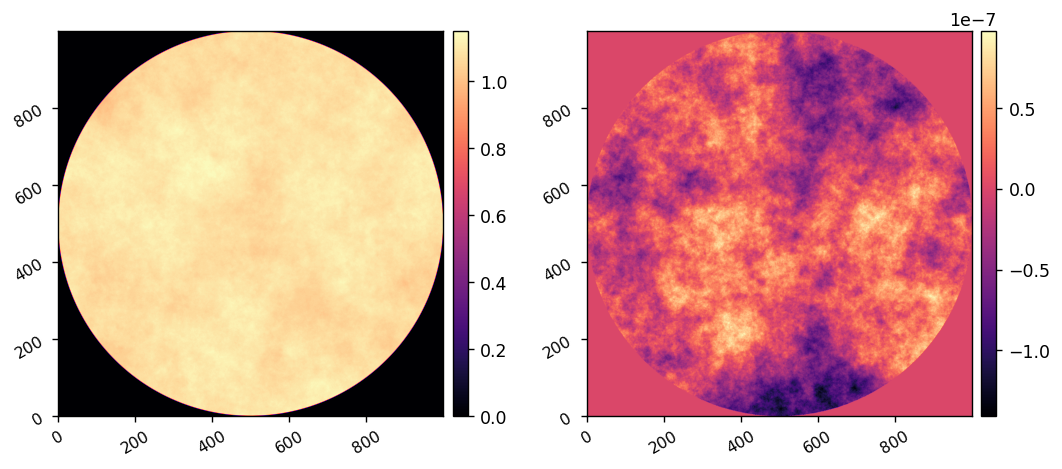

In [ ]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import adefc_1dm as adefc
import adefc_vortex.scoob_model as scoobm

wavelength_c = 633e-9

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_opd = utils.load_fits('example_wfe_opd.fits')
imshow2(wfe_amp, wfe_opd)



# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


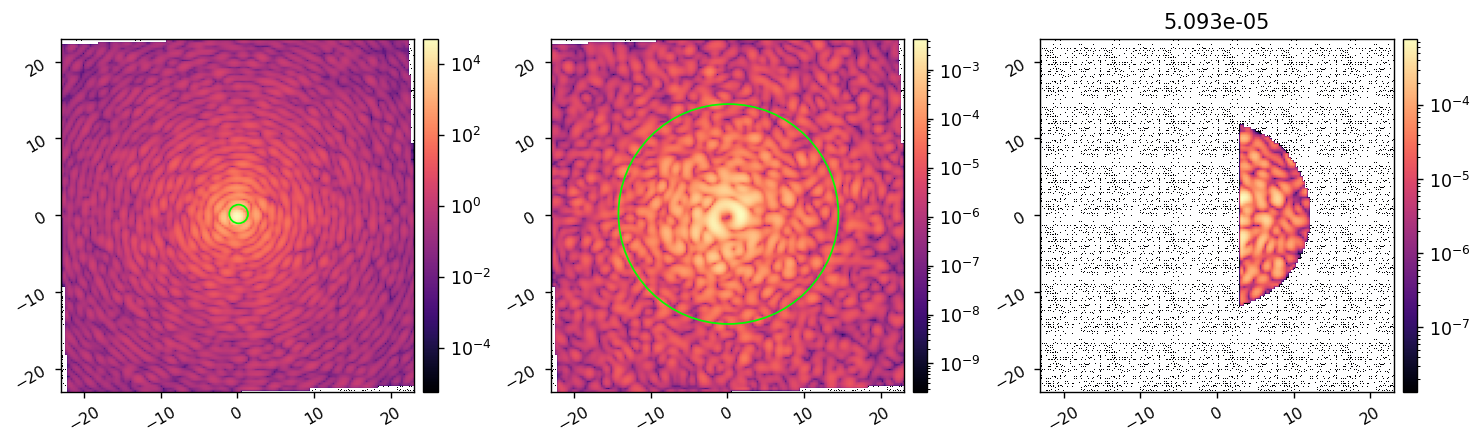

In [2]:
reload(scoobm)
I = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
I.AMP = wfe_amp
I.OPD = wfe_opd

# I.flip_dm = 1
# I.flip_lyot_ud = 1
# I.det_rotation = -7.5

I.reverse_lyot = 1
I.flip_lyot = 1
I.det_rotation = 178

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 3
owa = 12
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamDc/2, I.psf_pixelscale_lamDc/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')],
        )

Oversampling > 2x suggested for reliable results in Fresnel propagation.


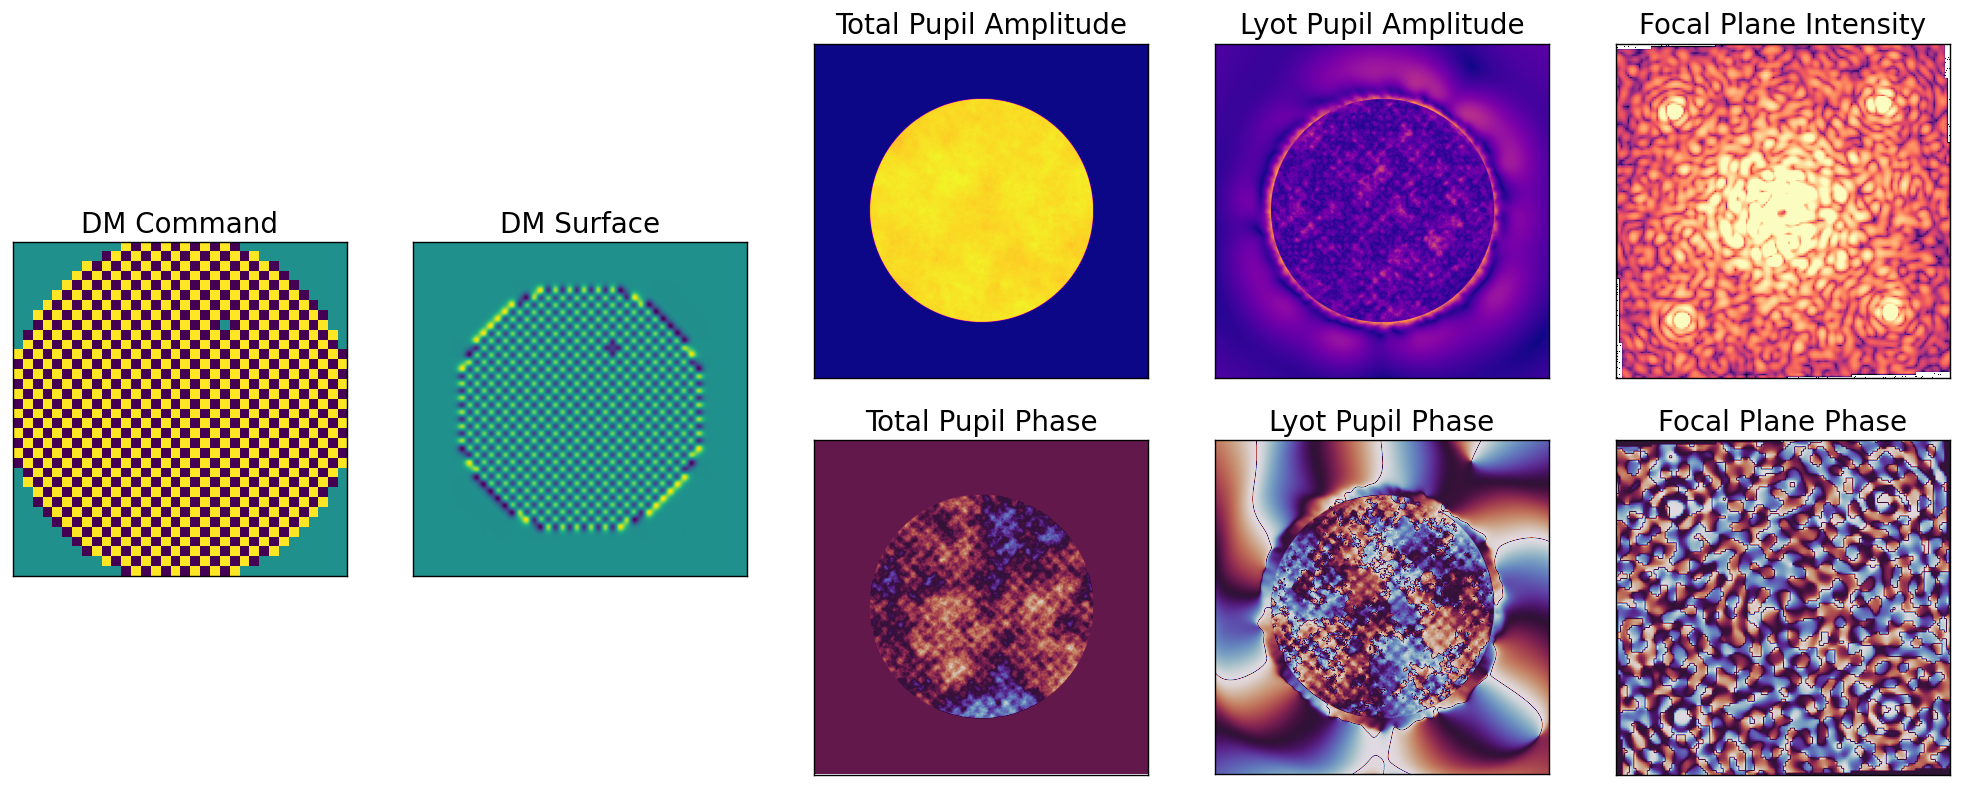

In [4]:
reload(scoobm)
reload(utils)
M = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

# M.flip_dm = 1
# M.flip_lyot_ud = 1
# M.det_rotation = -7.5

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

command = np.zeros((M.Nact, M.Nact))
command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
command = 20e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
# fpwf = M.forward(acts, use_vortex=0, plot=True)
fpwf = M.forward(command[M.dm_mask], use_vortex=1, plot=0, fancy_plot=1)


	Cost-function J_delE: 0.083
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.083
	Total cost-function value: 1.000



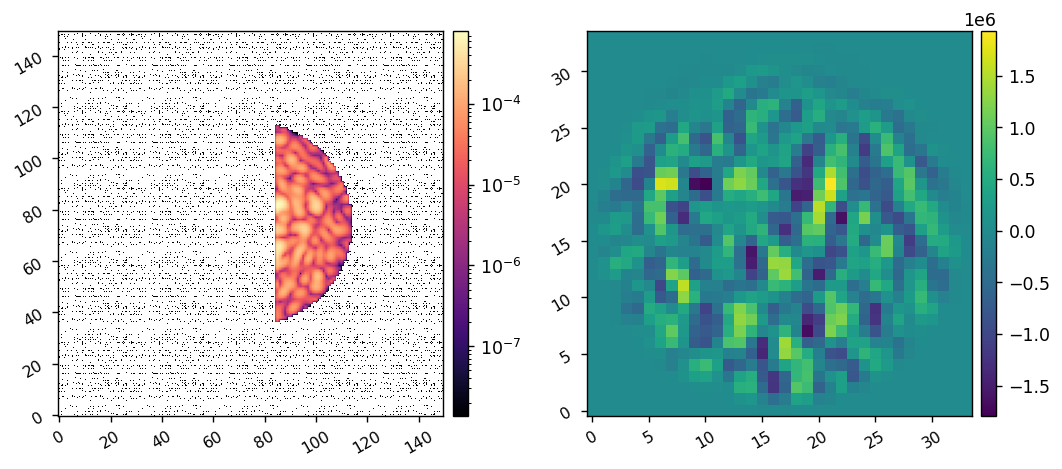

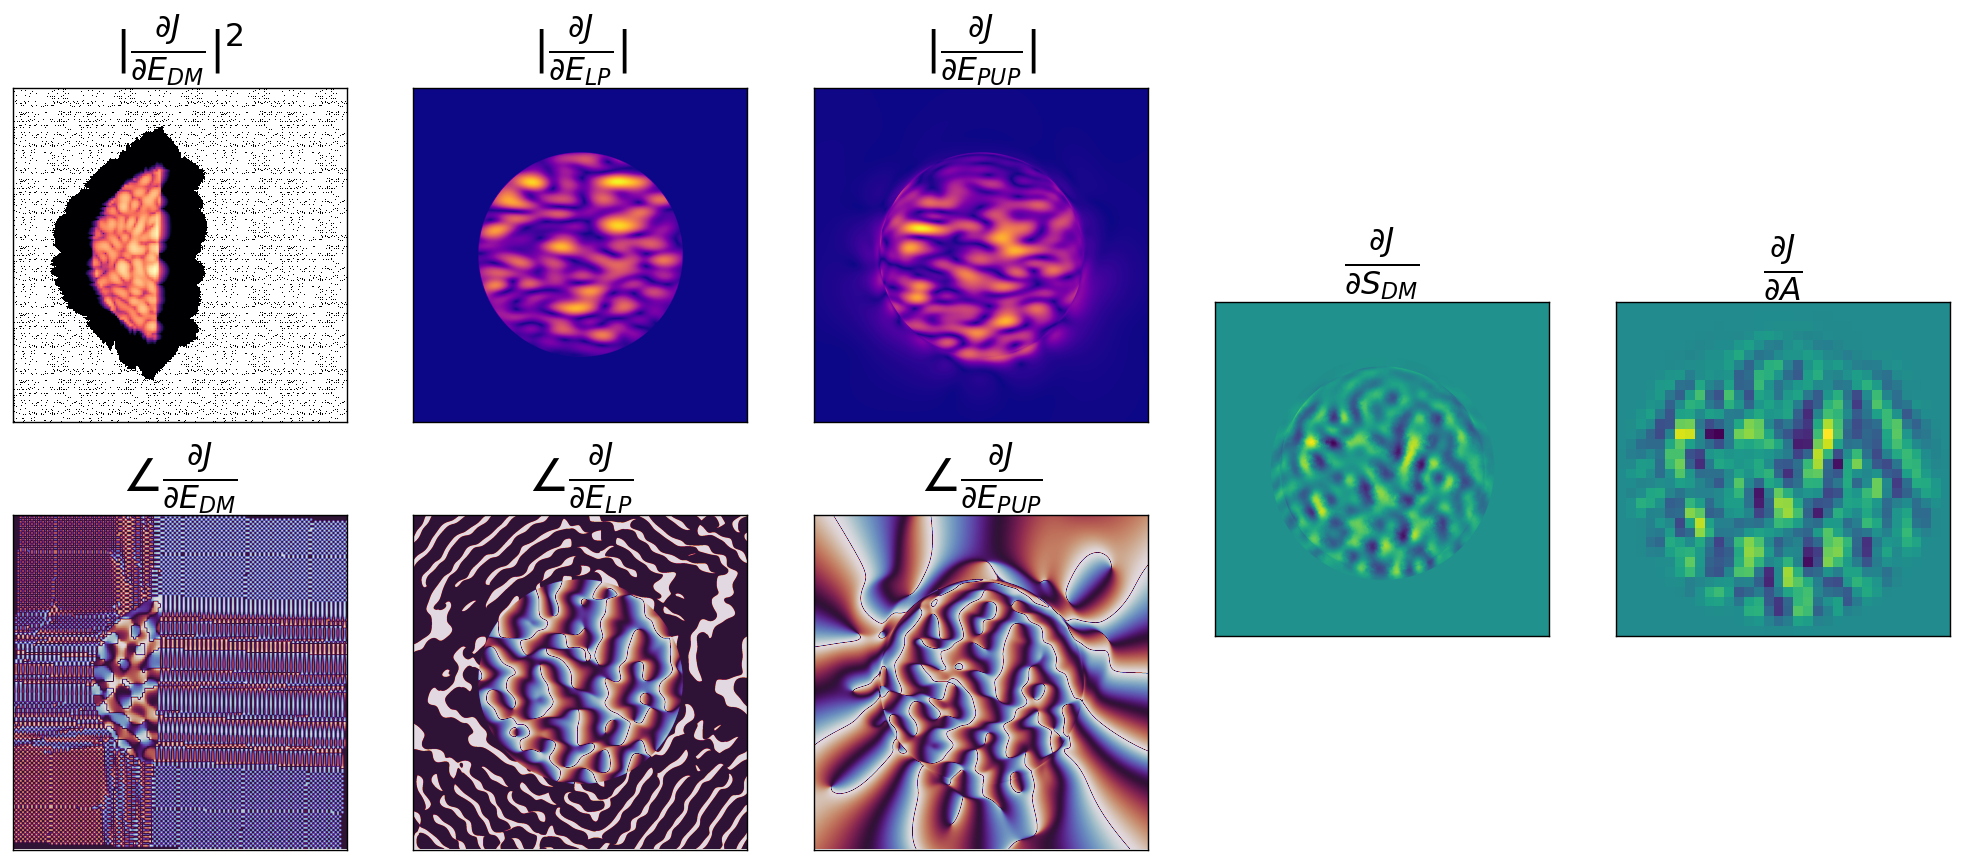

In [6]:
reload(scoobm)

current_acts = xp.zeros(I.Nacts)
# current_acts = xp.array(fits.getdata('ad_test_acts.fits'))

I.set_dm(scoobm.acts_to_command(current_acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_NOM, E_EP, DM_PHASOR = M.forward(current_acts, wavelength=I.wavelength_c, use_vortex=True, return_ints=True)

rmad_params = {
    'E_ab': E_ab,
    'current_acts': current_acts,
    'E_FP_NOM': E_FP_NOM, 
    'E_EP': E_EP, 
    'DM_PHASOR': DM_PHASOR,
    'control_mask': control_mask,
    'wavelength':I.wavelength_c,
    'r_cond': 1e-3, 
}

del_acts = xp.zeros(M.Nacts)
J, dJ_dA = scoobm.val_and_grad(del_acts, M, rmad_params, verbose=True, plot=0, fancy_plot=1)

dm_grad = scoobm.acts_to_command(dJ_dA, M.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True, cmap2='viridis')

In [8]:
reload(scoobm)
current_acts = xp.zeros(I.Nacts)
# current_acts = xp.array( fits.getdata('ad_test_acts.fits') )

I.set_dm(scoobm.acts_to_command(current_acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_NOM, E_EP, DM_PHASOR = M.forward(current_acts, wavelength=I.wavelength_c, use_vortex=True, return_ints=True)

rmad_params = {
    'E_ab': E_ab,
    'current_acts': current_acts,
    'E_FP_NOM': E_FP_NOM, 
    'E_EP': E_EP, 
    'DM_PHASOR': DM_PHASOR,
    'control_mask': control_mask,
    'wavelength':I.wavelength_c,
    'r_cond': 1e-3, 
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    scoobm.val_and_grad, 
    jac=True, 
    x0=del_acts0,
    args=(M, rmad_params, 0, 0, 0), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.92928D+06

At iterate    1    f=  1.72244D-01    |proj g|=  7.02119D+05

At iterate    2    f=  6.46306D-02    |proj g|=  2.70197D+05

At iterate    3    f=  3.15041D-02    |proj g|=  1.29769D+05

At iterate    4    f=  2.11895D-02    |proj g|=  1.14435D+05

At iterate    5    f=  1.48413D-02    |proj g|=  1.19011D+05

At iterate    6    f=  1.12030D-02    |proj g|=  6.28460D+04

At iterate    7    f=  8.73075D-03    |proj g|=  4.98941D+04

At iterate    8    f=  6.89058D-03    |proj g|=  5.37433D+04

At iterate    9    f=  5.82966D-03    |proj g|=  4.81663D+04

At iterate   10    f=  5.13825D-03    |proj g|=  2.83576D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

0.0


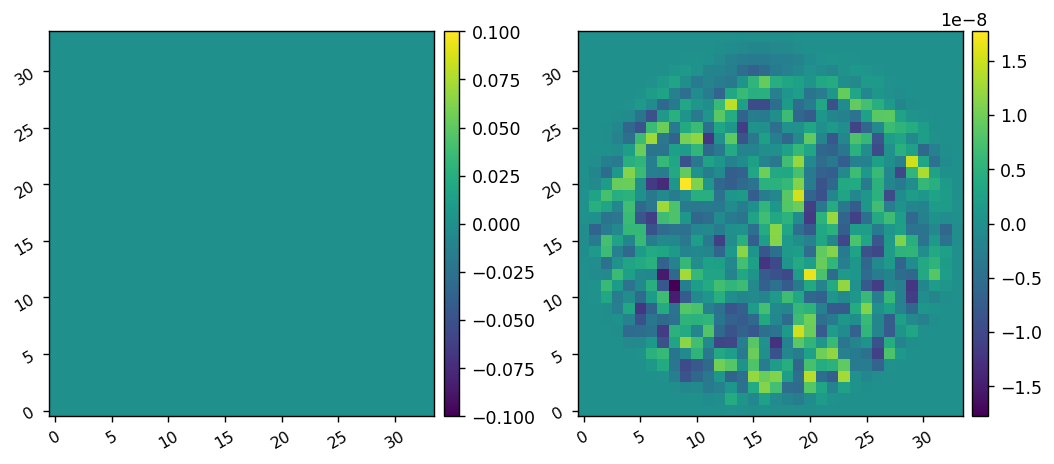

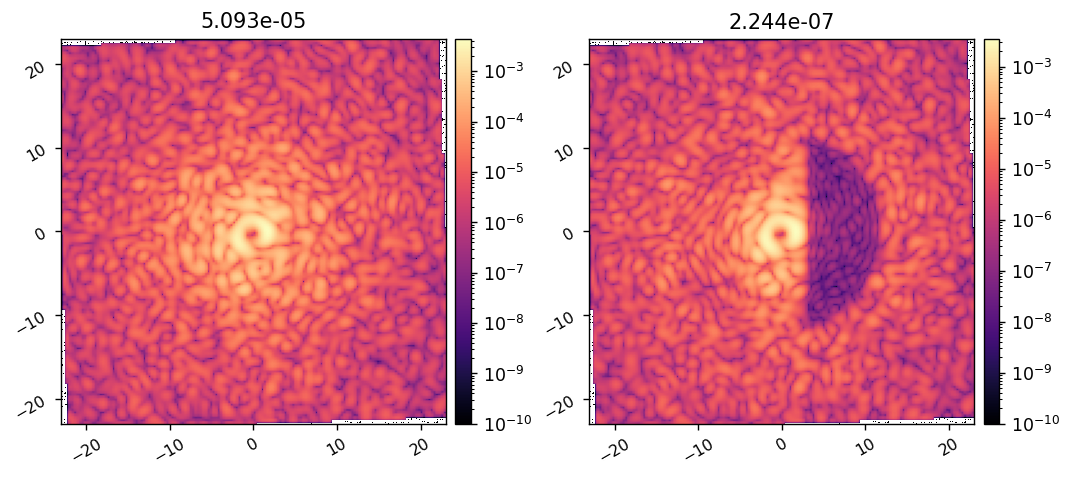

In [10]:
old_command = scoobm.acts_to_command(current_acts, I.dm_mask)
del_command = scoobm.acts_to_command(res.x, I.dm_mask)
print(del_command[25,21])

I.set_dm(old_command)
old_im = I.snap()
I.set_dm(old_command + del_command)
new_im = I.snap()

imshow2(old_command, del_command, cmap1='viridis', cmap2='viridis')
imshow2(old_im, new_im, 
        f'{xp.mean(old_im[control_mask]):.3e}', f'{xp.mean(new_im[control_mask]):.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, vmin1=1e-10, vmin2=1e-10)

In [32]:
utils.save_fits('ad_test_acts.fits', I.get_dm()[I.dm_mask])

Saved data to:  ad_test_acts.fits


In [11]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running estimation algorithm ...
Computing EFC command with L-BFGS


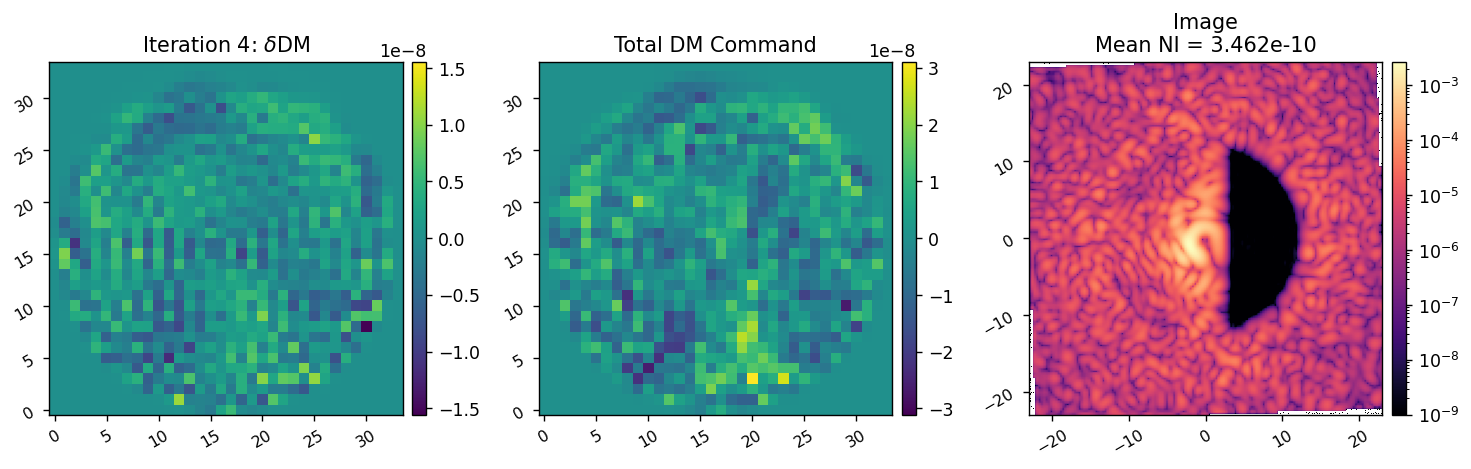

Running estimation algorithm ...
Computing EFC command with L-BFGS


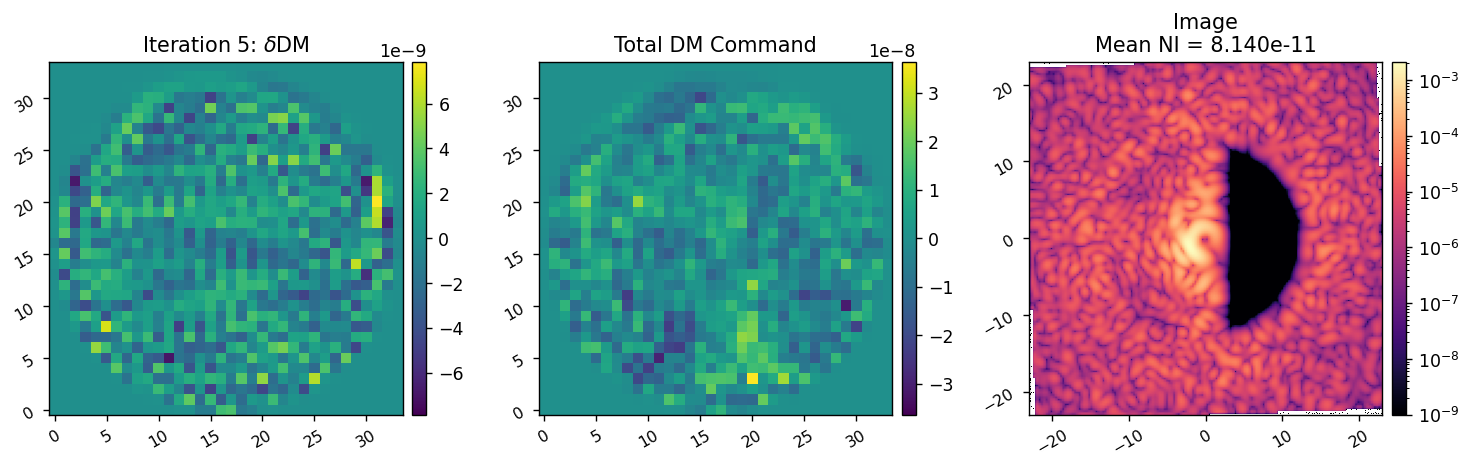

Running estimation algorithm ...
Computing EFC command with L-BFGS


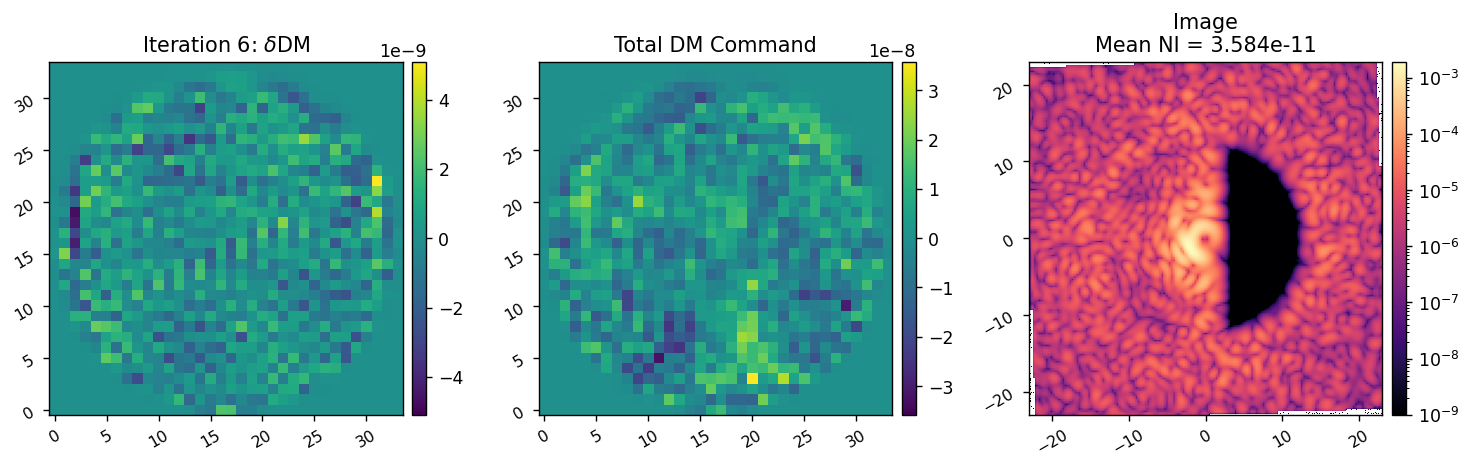

In [13]:
reload(scoobm)
reload(adefc)
reload(utils)

r_cond = 1e-1
r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
r_cond = 1e-6
# r_cond = 1e-7
# r_cond = 1e-8

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':0,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run(
    I, 
    M, 
    scoobm.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

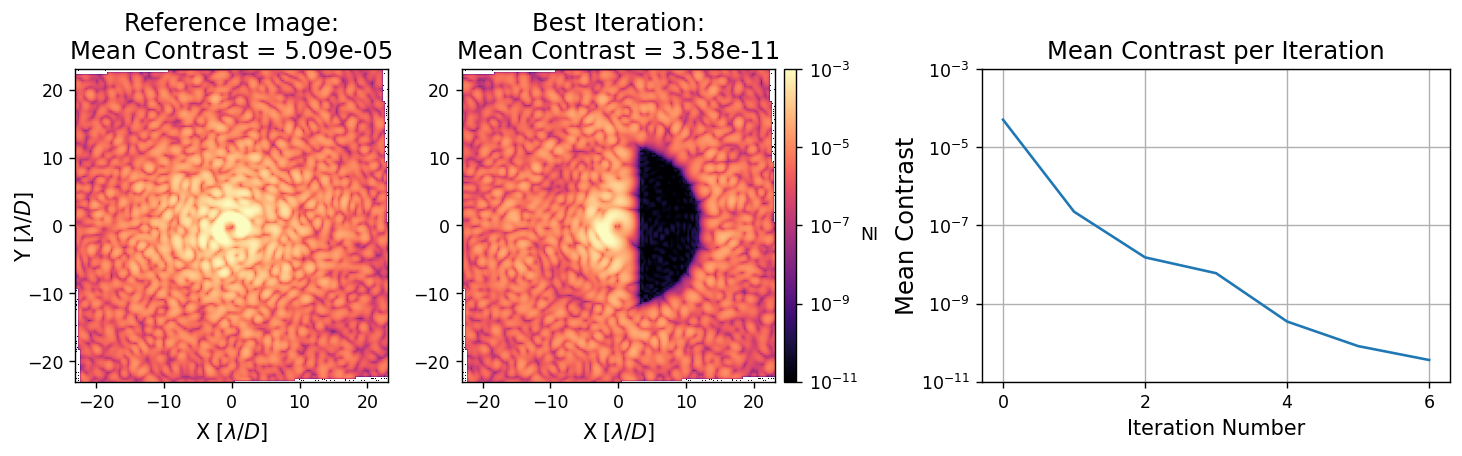

In [14]:
from adefc_vortex.imshows import plot_data
plot_data(data, vmin=1e-11, vmax=1e-3)
